<a href="https://colab.research.google.com/github/rodrigoromanguzman/Actividades_Aprendizaje-/blob/main/A3a_DL_TC5033_embeddings_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TC 5033
### Word Embeddings

<br>

#### Activity 3a: Exploring Word Embeddings with GloVe and Numpy
<br>

- Objective:
    - To understand the concept of word embeddings and their significance in Natural Language Processing.
    - To learn how to manipulate and visualize high-dimensional data using dimensionality reduction techniques like PCA and t-SNE.
    - To gain hands-on experience in implementing word similarity and analogies using GloVe embeddings and Numpy.
    
<br>

- Instructions:
    - Download GloVe pre-trained vectors from the provided link in Canvas, the official public project:
    Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation
    https://nlp.stanford.edu/data/glove.6B.zip

    - Create a dictorionay of the embeddings so that you carry out fast look ups. Save that dictionary e.g. as a serialized file for faster loading in future uses.
    
    - PCA and t-SNE Visualization: After loading the GloVe embeddings, use Numpy and Sklearn to perform PCA and t-SNE to reduce the dimensionality of the embeddings and visualize them in a 2D or 3D space.

    - Word Similarity: Implement a function that takes a word as input and returns the 'n' most similar words based on their embeddings. You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Word Analogies: Implement a function to solve analogies between words. For example, "man is to king as woman is to ____". You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Submission: This activity is to be submitted in teams of 3 or 4. Only one person should submit the final work, with the full names of all team members included in a markdown cell at the beginning of the notebook.
    
<br>

- Evaluation Criteria:

    - Code Quality (40%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity.
    
   - Functionality (60%): All functions should work as intended, without errors.
       - Visualization of PCA and t-SNE (10% each for a total of 20%)
       - Similarity function (20%)
       - Analogy function (20%)
|



#### Import libraries

In [1]:
# Import libraries
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import pickle

# Libraries for reading file from gdrive
from google.colab import drive

plt.style.use('ggplot')

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load file

In [3]:
# PATH = '/media/pepe/DataUbuntu/Databases/glove_embeddings/glove.6B.200d.txt'
# PATH = '/media/pepe/DataUbuntu/Databases/glove_embeddings/glove.6B.50d.txt'
PATH = '/content/drive/My Drive/glove.6B.50d.txt'
emb_dim = 50

In [4]:
# Create dictionary with embeddings
def create_emb_dictionary(path):
  dictionary = {}
  with open(PATH, 'r') as file:
    for line in file:
        # Split the line where a newline character is found
        line = line.strip()  # Remove leading/trailing whitespace, including newline characters
        words = line.split() # Split the elements of the line by their space
        if len(words)>=2:
          key = words[0] #Take the first element which is the word as a key
          value =  np.array(words[1:],dtype=float) #Use the rest of the elements as the numpy values
          dictionary[key] = value #Store the values in the dictionary
  return dictionary

In [5]:
# create dictionary
embeddings_dict = create_emb_dictionary(PATH)

<h2>
We serialize the embeddings_dict dictionary into a binary file for efficient storage and later retrieval, simplifying the process of accessing the dictionary's data.</h2>

In [6]:
# Serialize
with open('embeddings_dict_50D.pkl', 'wb') as f:
    pickle.dump(embeddings_dict, f)

# Deserialize
# with open('embeddings_dict_200D.pkl', 'rb') as f:
#     embeddings_dict = pickle.load(f)

#### See some embeddings

In [7]:
# Show some
def show_n_first_words(path, n_words):
        with open(path, 'r') as f:
            for i, line in enumerate(f):
                print(line.split(), len(line.split()[1:]))
                if i>=n_words: break

In [8]:
show_n_first_words(PATH, 5)

['the', '0.418', '0.24968', '-0.41242', '0.1217', '0.34527', '-0.044457', '-0.49688', '-0.17862', '-0.00066023', '-0.6566', '0.27843', '-0.14767', '-0.55677', '0.14658', '-0.0095095', '0.011658', '0.10204', '-0.12792', '-0.8443', '-0.12181', '-0.016801', '-0.33279', '-0.1552', '-0.23131', '-0.19181', '-1.8823', '-0.76746', '0.099051', '-0.42125', '-0.19526', '4.0071', '-0.18594', '-0.52287', '-0.31681', '0.00059213', '0.0074449', '0.17778', '-0.15897', '0.012041', '-0.054223', '-0.29871', '-0.15749', '-0.34758', '-0.045637', '-0.44251', '0.18785', '0.0027849', '-0.18411', '-0.11514', '-0.78581'] 50
[',', '0.013441', '0.23682', '-0.16899', '0.40951', '0.63812', '0.47709', '-0.42852', '-0.55641', '-0.364', '-0.23938', '0.13001', '-0.063734', '-0.39575', '-0.48162', '0.23291', '0.090201', '-0.13324', '0.078639', '-0.41634', '-0.15428', '0.10068', '0.48891', '0.31226', '-0.1252', '-0.037512', '-1.5179', '0.12612', '-0.02442', '-0.042961', '-0.28351', '3.5416', '-0.11956', '-0.014533', '-0.

### Plot some embeddings

In [9]:
def plot_embeddings(emb_path, words2show, emb_dim, embeddings_dict, dimensionReduce=PCA):
    dimensionReduce = dimensionReduce(n_components=2)
    transformed_data = dimensionReduce.fit_transform(np.array(list(embeddings_dict.values())))

    # Create a dictionary with the transformed data
    transformed_dict = {word: transformed_data[i] for i, word in enumerate(embeddings_dict.keys())}

    # Scatter plot the transformed data in 2D
    plt.figure(figsize=(10, 10))
    plot_values = np.array([transformed_dict[word] for word in words2show])
    plt.scatter(plot_values[:, 0], plot_values[:, 1], marker='o', s=50)

    # Add labels to the points
    for word in words2show:
        plt.annotate(word, transformed_dict[word], fontsize=10)

    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('dimensionReduce Plot in 2D')
    plt.show()



In [10]:
words= ['burger', 'tortilla', 'bread', 'pizza', 'beef', 'steak', 'fries', 'chips',
            'argentina', 'mexico', 'spain', 'usa', 'france', 'italy', 'greece', 'china',
            'water', 'beer', 'tequila', 'wine', 'whisky', 'brandy', 'vodka', 'coffee', 'tea',
            'apple', 'banana', 'orange', 'lemon', 'grapefruit', 'grape', 'strawberry', 'raspberry',
            'school', 'work', 'university', 'highschool']


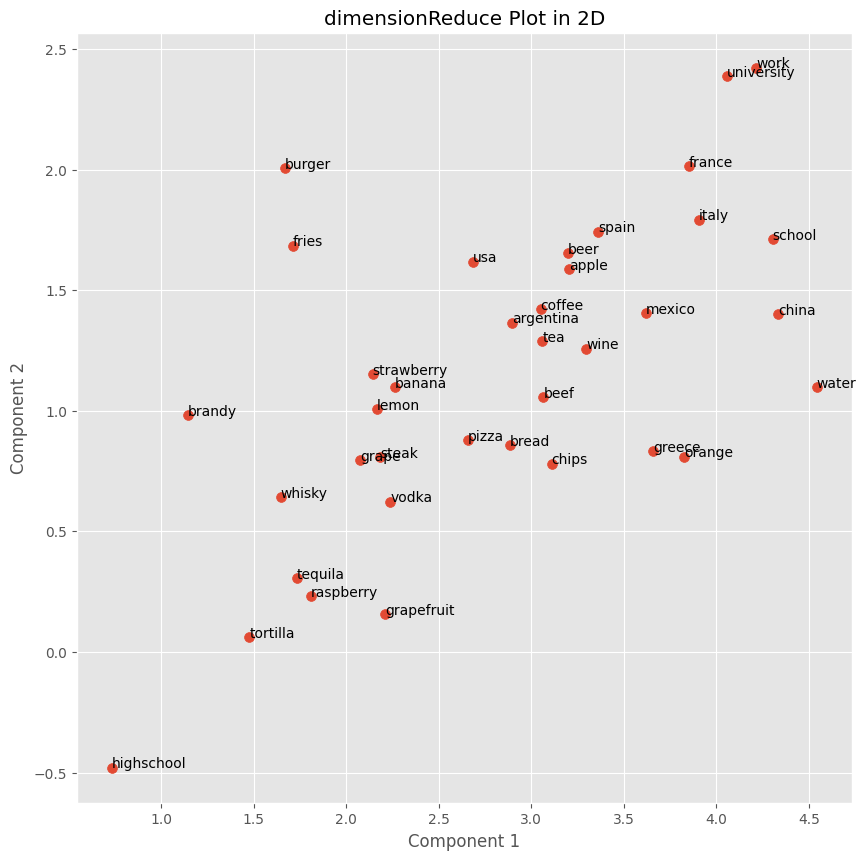

In [11]:
plot_embeddings(PATH, words, emb_dim, embeddings_dict,PCA)

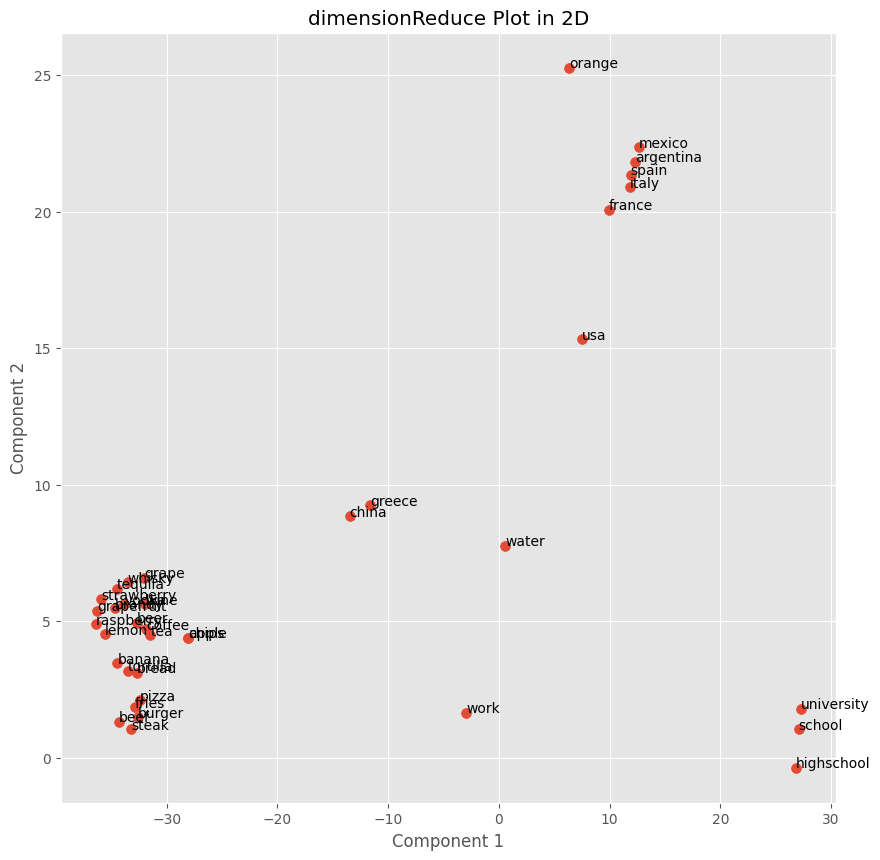

In [19]:
# t-SNE dimensionality reduction for visualization
# TSNE is a very expensive algorithm. So we have to reduce the size
# of the dictionary before passing it to the plot function
reduced_dictionary = dict(list(embeddings_dict.items())[:1000])
# We just make sure that the words we need will be there
for i in words:
  reduced_dictionary[i] = embeddings_dict[i]
embeddings = plot_embeddings(PATH, words, emb_dim, reduced_dictionary,TSNE)

### Let us compute analogies

<h2>How to compute analogies?</2>
<p>Reviewing the GloVe article: Global Vectors for Word Representation we can see that: "We answer the question “a is to b as c is to ?” by finding the word d whose representation $w_4$ is closest to $$w_2 − w_1 + w_3$$ according
to the cosine similarity."</p>

In [13]:
# analogy
def analogy(word1, word2, word3, embeddings_dict):
  current_minimum = float("inf")
  target_vector = embeddings_dict[word2] - embeddings_dict[word1] + embeddings_dict[word3]
  word4 = "NONE"
  for key, current in embeddings_dict.items():
    word3_current_distance = np.linalg.norm(target_vector - current)
    if(word3_current_distance < current_minimum and (key not in [word1, word2, word3])):
      current_minimum =  word3_current_distance
      word4 = key
  return word4

In [14]:
analogy('man', 'king', 'woman', embeddings_dict)

'queen'

In [15]:
analogy('paris', 'france', 'rome', embeddings_dict)

'italy'

<h2>Find most similar words</h2>
<p>We order the most similar words from the most similar to the least similar</p>

In [16]:
# most similar
def find_most_similar(word, embeddings_dict, top_n=10):

  # Create a copy of the key, vector elements of the dictionary
  key_vector_distance = list(embeddings_dict.items())
  for idx,(key, current) in enumerate(embeddings_dict.items()):

    # Compute the distance between the word and all the other vectors
    distance_word_current = np.linalg.norm(embeddings_dict[word] - current)

    # Save the distance into as an element of the tuple
    key_vector_distance[idx] = key_vector_distance[idx] + (distance_word_current,)

  # Sort by the last element of the tuple
  sorted_list = sorted(key_vector_distance, key=lambda x: x[-1])

  # Return the last 10 elements without taking the first one which is the
  # actual word
  return sorted_list[1:11:]



In [17]:
most_similar = find_most_similar('mexico', embeddings_dict)

In [18]:
for i, w in enumerate(most_similar, 1):
    print(f'{i} ---> {w[0]}')

1 ---> venezuela
2 ---> peru
3 ---> mexican
4 ---> chile
5 ---> colombia
6 ---> puerto
7 ---> rico
8 ---> guatemala
9 ---> panama
10 ---> costa
